# Problem Description

## Background

In the field of bioinformatics, known protein sequences have grown rapidly due to advances in sequencing technologies, but determining the biological function of them remains a slow and expensive process. Traditional sequence alignment methods (like BLAST) rely on homology to known proteins.

Given that, the core problem this project addresses is: Can we identify biological functional groups (e.g., Enzymes or Toxins) solely by analyzing the physical and chemical characteristics derived from their amino acid sequences?


### Rationale: Why Unsupervised Learning?

While state-of-the-art Deep Learning models (e.g., [AlphaFold 2](https://www.nature.com/articles/s41586-021-03819-2) for structure prediction or Protein Language Models for embedding) have achieved breakthrough performance, they often operate as "black boxes" requiring massive computational resources.

Therefore, this project intentionally adopts classical unsupervised algorithms, so that I can establish a baseline and make the results easy to understand.


## Data Source

As the data source, I used [Protein Data Set hosted on Kaggle](https://www.kaggle.com/datasets/shahir/protein-data-set), which aggregates structural data from the known databases like Protein Data Bank (PDB).

# Prepare Data

This section contains:
- Download and load the data from Kaggle
- EDA (Exploratory Data Analysis)
- Data cleaning and sampling

In [24]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import os

path = kagglehub.dataset_download("shahir/protein-data-set")
print("Downloaded Data Files:", os.listdir(path))

df_meta = pd.read_csv(os.path.join(path, "pdb_data_no_dups.csv")) # Metadata
df_seq = pd.read_csv(os.path.join(path, "pdb_data_seq.csv")) # Sequence data

Using Colab cache for faster access to the 'protein-data-set' dataset.
Downloaded Data Files: ['pdb_data_seq.csv', 'pdb_data_no_dups.csv']


## EDA (Exploratory Data Analysis)

In [25]:
# Check original column and sample values

print("\n", "=" * 20, "Metadata (pdb_data_no_dups.csv)", "=" * 20)
print("Columns:", df_meta.columns.tolist(), "\n")
print(df_meta.head())
print("\n\n", "=" * 20, "Sequence (pdb_data_seq.csv)", "=" * 20)
print("Columns:", df_seq.columns.tolist(), "\n")
print(df_seq.head())


 ==================== Metadata (pdb_data_no_dups.csv) ====================
Columns: ['structureId', 'classification', 'experimentalTechnique', 'macromoleculeType', 'residueCount', 'resolution', 'structureMolecularWeight', 'crystallizationMethod', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'pdbxDetails', 'phValue', 'publicationYear'] 

  structureId         classification experimentalTechnique macromoleculeType  \
0        100D         DNA-RNA HYBRID     X-RAY DIFFRACTION    DNA/RNA Hybrid   
1        101D                    DNA     X-RAY DIFFRACTION               DNA   
2        101M       OXYGEN TRANSPORT     X-RAY DIFFRACTION           Protein   
3        102D                    DNA     X-RAY DIFFRACTION               DNA   
4        102L  HYDROLASE(O-GLYCOSYL)     X-RAY DIFFRACTION           Protein   

   residueCount  resolution  structureMolecularWeight  \
0            20        1.90                   6360.30   
1            24        2.25                   

After inspecting `df_meta` (metadata) and `df_seq` (sequence), it's clear they contain complementary information. To enable holistic analysis, these two dataframes must be joined on `structureId`, which is a unique identifier shared by both.

In [26]:
# Merge two data into one DataFrame
df = df_meta.merge(
    df_seq[['structureId', 'chainId', 'sequence']], # pick these 3 columns from sequence data to merge
    on='structureId',
    how='inner'
)
# df.shape # => 471149 rows, 16 columns
df

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


Before moving further, I would examine the raw merged dataset to understand its characteristics and identify potential data quality issues. Key objectives include assessing the balance of protein classifications, check sequence length, and prify the dataset so that it's suitable for our unsupervised learning.

In [27]:
print("=== 1. Check Basic Statistics and Missing Values ===")
print(f"Total records: {len(df)}")

# Check for missing values: This result provides the rationale for needing 'dropna' later
print("-" * 30)
print(df[['classification', 'sequence', 'macromoleculeType']].isnull().sum())
print("-" * 30)

# Check data types
print(df.info())

=== 1. Check Basic Statistics and Missing Values ===
Total records: 471149
------------------------------
classification           4
sequence                28
macromoleculeType    35770
dtype: int64
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471149 entries, 0 to 471148
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               471149 non-null  object 
 1   classification            471145 non-null  object 
 2   experimentalTechnique     471149 non-null  object 
 3   macromoleculeType         435379 non-null  object 
 4   residueCount              471149 non-null  int64  
 5   resolution                449486 non-null  float64
 6   structureMolecularWeight  471149 non-null  float64
 7   crystallizationMethod     314754 non-null  object 
 8   crystallizationTempK      317697 non-null  float64
 9   densityMatthews           389645 non-

Also, I would visually show the distribution of classification, sequence length, and macromolecule types.

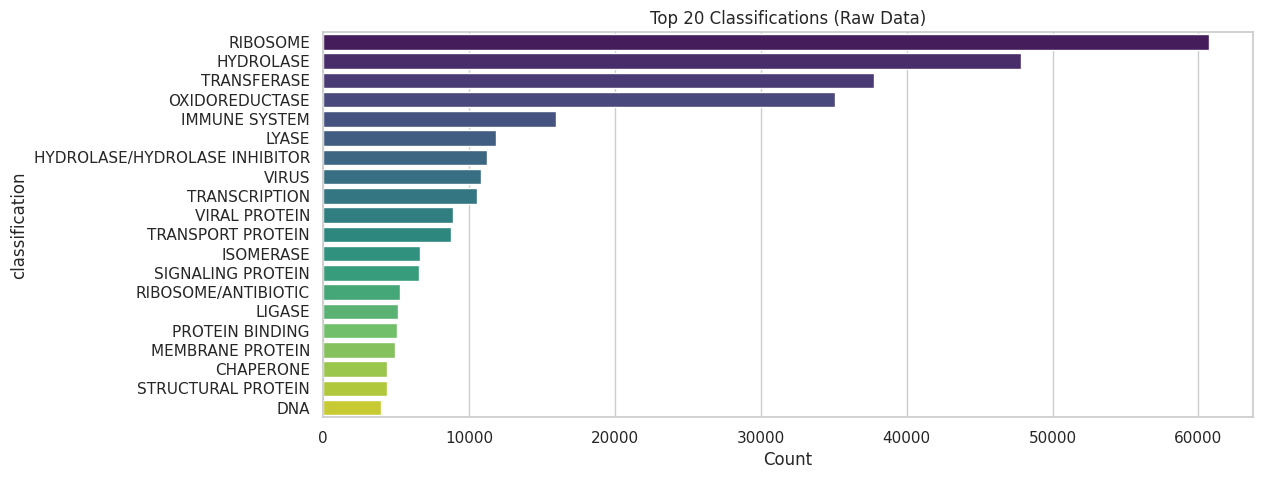

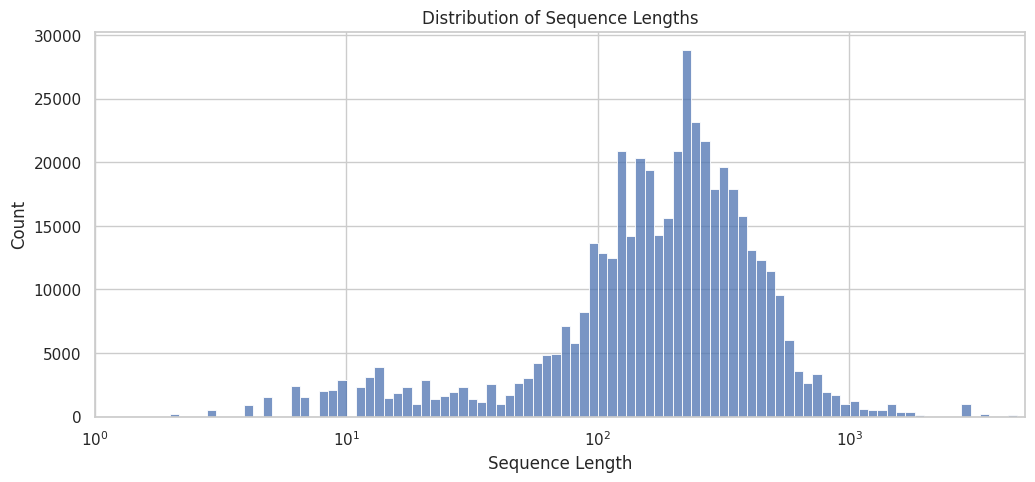

Min Length: 1, Max Length: 5070, Mean Length: 247.5


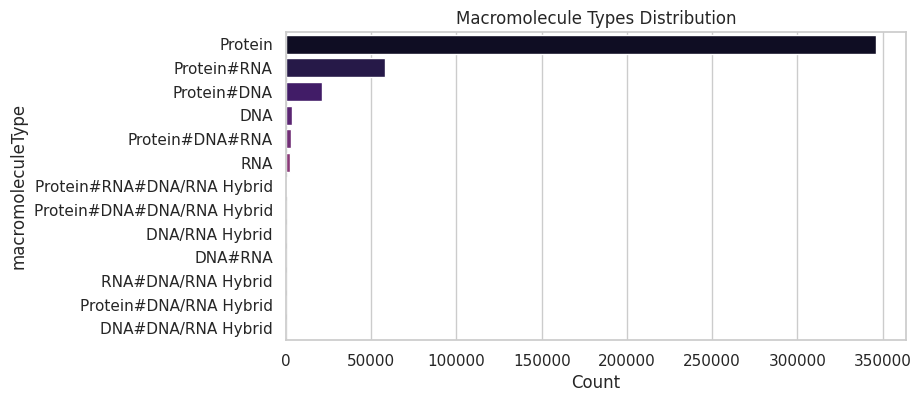

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# 1. Classification Distribution
plt.figure()
top_20_classes = df['classification'].value_counts().head(20)

sns.barplot(
    x=top_20_classes.values,
    y=top_20_classes.index,
    hue=top_20_classes.index,
    legend=False,
    palette='viridis'
)
plt.title('Top 20 Classifications (Raw Data)')
plt.xlabel('Count')
plt.show()

# 2. Sequence Length Distribution
seq_lengths = df['sequence'].dropna().str.len()

plt.figure()
sns.histplot(seq_lengths, bins=100, log_scale=(True, False))
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.xlim(1, 5000)
plt.show()

print(f"Min Length: {seq_lengths.min()}, Max Length: {seq_lengths.max()}, Mean Length: {seq_lengths.mean():.1f}")

# 3. Macromolecule Type Distribution
plt.figure(figsize=(8, 4))
type_counts = df['macromoleculeType'].value_counts()
sns.barplot(
    x=type_counts.values,
    y=type_counts.index,
    hue=type_counts.index,
    legend=False,
    palette='magma'
)
plt.title('Macromolecule Types Distribution')
plt.xlabel('Count')
plt.show()

Based on the insights from the EDA, now I will clean and preprocess the dataset to ensure high-quality input for the unsupervised learning model.

## Data Cleaning

Cleaning Steps:
1. Filter for Pure Proteins ... Remove records where `macromoleculeType` is not `Protein` (e.g., DNA/RNA).
2. Length Filtering ... Set max/min filter for the sequence lengths
3. Remove Non-Standard Sequences ... Exclude sequences containing ambiguous amino acid codes (e.g., 'X', 'Z').
4. Focus on Top Categories ... To address the class imbalance observed in the EDA, restrict the dataset to the Top 10 classifications.
5. Sampling ... I will downsample the data to have an equal number of samples for each of the top 10 classes.

In [29]:
# Configuration
RANDOM_STATE = 424242
TOP_N_CLASSES = 10      # Number of top categories to analyze
SAMPLES_PER_CLASS = 500 # Number of samples per class (Total will be `TOP_N_CLASSES x SAMPLES_PER_CLASS`)
MIN_SEQ_LEN = 50        # Exclude fragments shorter than this
MAX_SEQ_LEN = 2000      # Exclude giant proteins longer than this (to reduce computational cost)

# Definition of standard amino acids (exclude sequences containing others)
STANDARD_AMINO_ACIDS = set("ACDEFGHIKLMNPQRSTVWY")

def clean_and_sample_data(df):
    print(f"Original shape: {df.shape}")

    # 1. Filter for Pure Proteins
    # Remove non-protein entries (e.g., DNA/RNA hybrids) as they distort physicochemical calculations.
    df_clean = df[df['macromoleculeType'] == 'Protein'].copy()
    print(f"Shape after keeping only 'Protein': {df_clean.shape}")

    # 2. Length Filtering
    # Exclude extremely short or long sequences
    df_clean = df_clean[
        (df_clean['sequence'].str.len() >= MIN_SEQ_LEN) &
        (df_clean['sequence'].str.len() <= MAX_SEQ_LEN)
    ]

    # 3. Remove Non-Standard Amino Acids
    valid_mask = df_clean['sequence'].apply(lambda seq: set(seq).issubset(STANDARD_AMINO_ACIDS))
    df_clean = df_clean[valid_mask]
    print(f"Shape after removing non-standard sequences: {df_clean.shape}")

    # 4. Select Top N Classes
    # Identify the top N most frequent classes to focus on major functions.
    top_classes = df_clean['classification'].value_counts().nlargest(TOP_N_CLASSES).index
    df_focused = df_clean[df_clean['classification'].isin(top_classes)]
    print(f"Selected Top {TOP_N_CLASSES} classes: {list(top_classes)}")

    # 5. Stratified Sampling (Crucial for Balancing)
    # Randomly sample an equal number of records from each class to prevent bias.
    df_sampled = df_focused.groupby('classification').sample(
        n=SAMPLES_PER_CLASS,
        random_state=RANDOM_STATE
    ).reset_index(drop=True)

    print("-" * 30)
    print(f"Final sampled shape: {df_sampled.shape}")
    return df_sampled

# --- Execution ---
# Use the DataFrame 'df' from the EDA step
df_final = clean_and_sample_data(df)

# Verify result: Each class should have exactly 500 samples
print("\nClass distribution in processed dataset:")
print(df_final['classification'].value_counts())

Original shape: (471149, 16)
Shape after keeping only 'Protein': (346325, 16)
Shape after removing non-standard sequences: (318904, 16)
Selected Top 10 classes: ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM', 'LYASE', 'HYDROLASE/HYDROLASE INHIBITOR', 'TRANSPORT PROTEIN', 'VIRAL PROTEIN', 'TRANSCRIPTION', 'VIRUS']
------------------------------
Final sampled shape: (5000, 16)

Class distribution in processed dataset:
classification
HYDROLASE                        500
HYDROLASE/HYDROLASE INHIBITOR    500
IMMUNE SYSTEM                    500
LYASE                            500
OXIDOREDUCTASE                   500
TRANSCRIPTION                    500
TRANSFERASE                      500
TRANSPORT PROTEIN                500
VIRAL PROTEIN                    500
VIRUS                            500
Name: count, dtype: int64


Next, let's visualize the cleaned data.

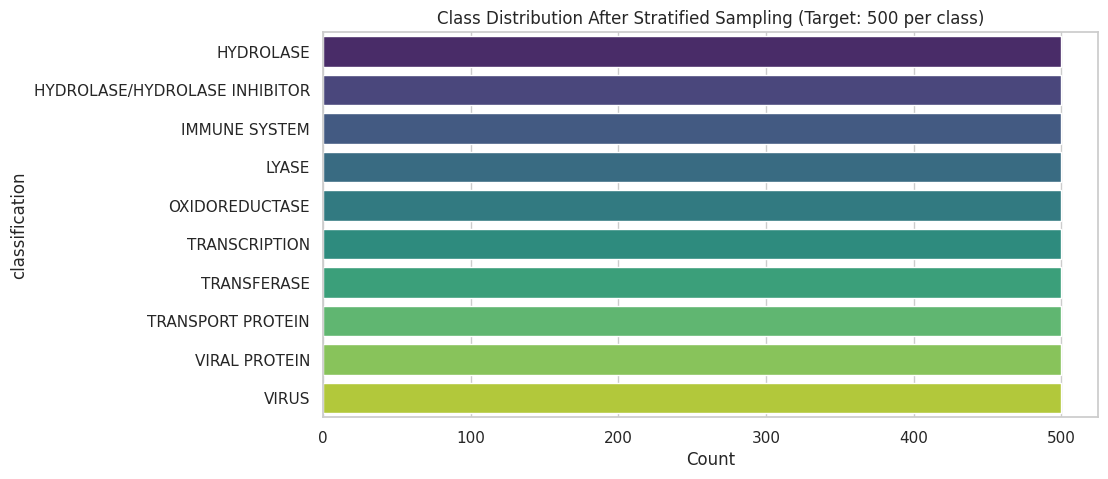

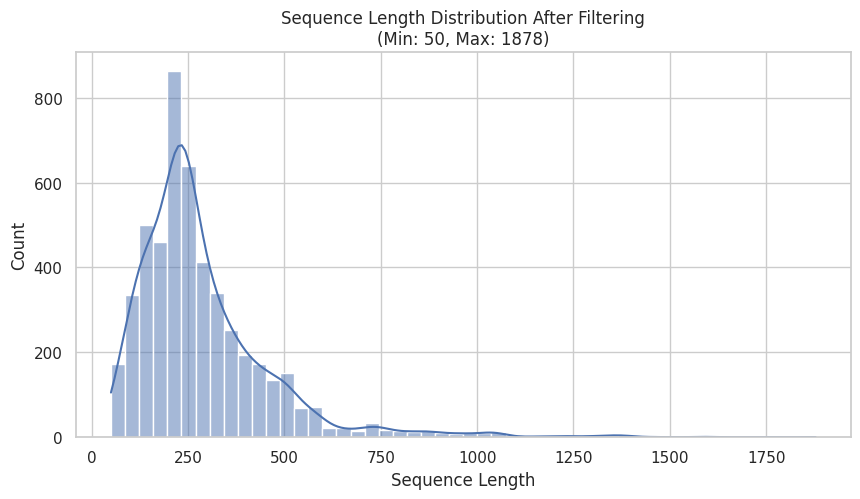

Final Data Shape: (5000, 16)
Unique Classes: 10


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Every class now has exactly 500 samples (Perfectly Balanced).
plt.figure()
sns.countplot(
    y='classification',
    data=df_final,
    order=df_final['classification'].value_counts().index,
    palette='viridis',
    hue='classification',
    legend=False
)
plt.title('Class Distribution After Stratified Sampling (Target: 500 per class)')
plt.xlabel('Count')
plt.show()

# Show that small (<50) and huge (>2000) proteins are removed.
seq_lengths = df_final['sequence'].str.len()

plt.figure()
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title(f'Sequence Length Distribution After Filtering\n(Min: {seq_lengths.min()}, Max: {seq_lengths.max()})')
plt.xlabel('Sequence Length')
plt.show()

print(f"Final Data Shape: {df_final.shape}")
print(f"Unique Classes: {df_final['classification'].nunique()}")

# Analysis

## Model Building and Training Strategy

Based on EDA, data clearning, and sampling, I have established a high-quality, balanced dataset of 5,000 protein sequences.

**Transition to Analysis:**
Amino acid strings cannot be directly processed by distance-based algorithms, so the next step is to transform these biological sequences into physical and chemical properties, that can be expressed as numerical values.

Next steps would be:
1. **Feature Extraction:** I will utilize the `Biopython` library to calculate key attributes such as *Molecular Weight*, *Isoelectric Point (pI)*, and *Hydrophobicity (GRAVY)* for each sequence.
2. **Standardization:** Since these features have different scales (e.g., weight in Daltons vs. hydrophobicity index), I will apply standard scaling.
3. **Unsupervised Learning:** Finally, I will apply clustering algorithms to discover if proteins with similar functions group together in this feature space.

### Feature Engineering (Preprocessing) using Biopython

To apply machine learning algorithms, I will transform the amino acid sequences into numerical feature vectors. Using the `Biopython` library, I extracted five key physical and chemical properties that define protein behavior:

1. **Molecular Weight:** Mass of the protein.
2. **Isoelectric Point (pI):** pH at which the protein carries no net electrical charge.
3. **Instability Index:** Estimate of protein stability in vitro.
4. **Aromaticity:** Relative frequency of aromatic amino acids.
5. **GRAVY:** Grand Average of Hydropathy (hydrophobicity; water interaction).

In [31]:
# Install Biopython if not already installed
!pip install biopython

In [32]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define extraction function
def get_physicochemical_features(seq):
    try:
        analyzer = ProteinAnalysis(str(seq))
        return {
            'Molecular_Weight': analyzer.molecular_weight(),
            'Isoelectric_Point': analyzer.isoelectric_point(),
            'Instability_Index': analyzer.instability_index(),
            'Aromaticity': analyzer.aromaticity(),
            'GRAVY': analyzer.gravy()
        }
    except:
        return None

# Apply to dataset
print("Extracting features...")
features_list = df_final['sequence'].apply(get_physicochemical_features).tolist()
df_features = pd.DataFrame(features_list)
df_analysis = pd.concat([df_final.reset_index(drop=True), df_features], axis=1).dropna()
print("Done")

df_analysis

Extracting features...
Done


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,...,pdbxDetails,phValue,publicationYear,chainId,sequence,Molecular_Weight,Isoelectric_Point,Instability_Index,Aromaticity,GRAVY
0,3EIY,HYDROLASE,X-RAY DIFFRACTION,Protein,196,2.10,22141.13,"VAPOR DIFFUSION, SITTING DROP",289.0,3.81,...,"100 MM NA/K PHOSPHATE, PH 6.3, 49.5% PEG 200. ...",6.3,2009.0,A,MAHHHHHHMGTLEAQTQGPGSMSFSNVPAGKDLPQDFNVIIEIPAQ...,21444.3741,5.957715,25.634184,0.076531,-0.183673
5,1XKG,HYDROLASE,X-RAY DIFFRACTION,Protein,312,1.61,35889.37,"VAPOR DIFFUSION, SITTING DROP",298.0,2.23,...,"PEG-4000, ammonium sulfate, sodium acetate, gl...",4.6,2005.0,A,RPSSIKTFEEYKKAFNKSYATFEDEEAARKNFLESVKYVQSNGGAI...,35381.8040,5.854666,35.916987,0.115385,-0.549038
6,1I2S,HYDROLASE,X-RAY DIFFRACTION,Protein,564,1.70,63002.47,"VAPOR DIFFUSION, HANGING DROP",293.0,2.57,...,"PEG 6000, sodium citrate, pH 5.0, VAPOR DIFFUS...",5.0,2002.0,A,GCANNQTNASQPAEKNEKTEMKDDFAKLEEQFDAKLGIFALDTGTN...,31245.7749,5.099674,23.218085,0.056738,-0.622695
8,3TTY,HYDROLASE,X-RAY DIFFRACTION,Protein,4050,2.25,465953.53,"VAPOR DIFFUSION, HANGING DROP",295.0,2.66,...,"6-9% PEG 3350, 0.1M magnesium sulfate, 0.1M bi...",8.5,2012.0,F,MINEKFPKIWYGGDYNPEQWDKATMEEDMRMFNLAGIDVATVNVFS...,77326.6237,5.383926,40.761067,0.124444,-0.423111
10,1ZCC,HYDROLASE,X-RAY DIFFRACTION,Protein,1488,2.50,165090.97,"VAPOR DIFFUSION, SITTING DROP",293.0,2.93,...,"Ammonium sulfate, PEG8K, HEPES, pH 7.0, VAPOR ...",7.0,2006.0,D,MTKIVSHRGANRFAPENTFAAADLALQQGADYIELDVRESADGVLY...,27326.7259,5.248365,43.475847,0.076613,-0.105645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,3KIE,VIRUS,X-RAY DIFFRACTION,Protein,14720,3.00,1646368.88,hanging drop,298.0,2.37,...,"3.2-3.4% PEG 6000, 50mM magnesium chloride, 10...",7.3,2010.0,L,MAADGYLPDWLEDNLSEGIREWWALKPGVPQPKANQQHQDNRRGLV...,81905.5374,5.933104,43.254905,0.105978,-0.747554
4987,4V4M,VIRUS,X-RAY DIFFRACTION,Protein,11760,1.45,1308065.88,"VAPOR DIFFUSION, HANGING DROP",298.0,3.24,...,"0.4 % PEG 6000, pH 6.2, 1 mM MgCl2, VAPOR DIFF...",6.2,2011.0,l,MAKQQNNRRKSATMRAVKRMINTHLEHKRFALINSGNTNATAGTVQ...,21714.4091,9.995065,25.187245,0.066327,-0.300510
4988,4PB6,VIRUS,X-RAY DIFFRACTION,Protein,10900,8.00,3557856.75,"VAPOR DIFFUSION, HANGING DROP",293.0,3.24,...,"reservoir solution: 7 - 10 % PEG 6000, 0.1 M H...",7.0,2015.0,J,MADDGSITAPEQGTLVGGVIAEPSAQMSAAADMATGKSVDSEWEAF...,59246.2876,5.410924,24.008275,0.095413,-0.052477
4992,4QYK,VIRUS,X-RAY DIFFRACTION,Protein,17520,3.50,1943095.88,"VAPOR DIFFUSION, SITTING DROP",293.0,4.21,...,"0.2 M magnesium acetate tetrahydrate, 0.1 M so...",6.5,2015.0,O,MSDGAVQPDGGQPAVRNERATGSGNGSGGGGGGGSGGVGISTGTFN...,64691.2255,5.516702,29.113904,0.113014,-0.503596


### Standard Scaling

Finally, I applied **Standard Scaling** to normalize these features, ensuring that attributes with larger magnitudes (like Molecular Weight) do not dominate distance-based algorithms like K-Means.

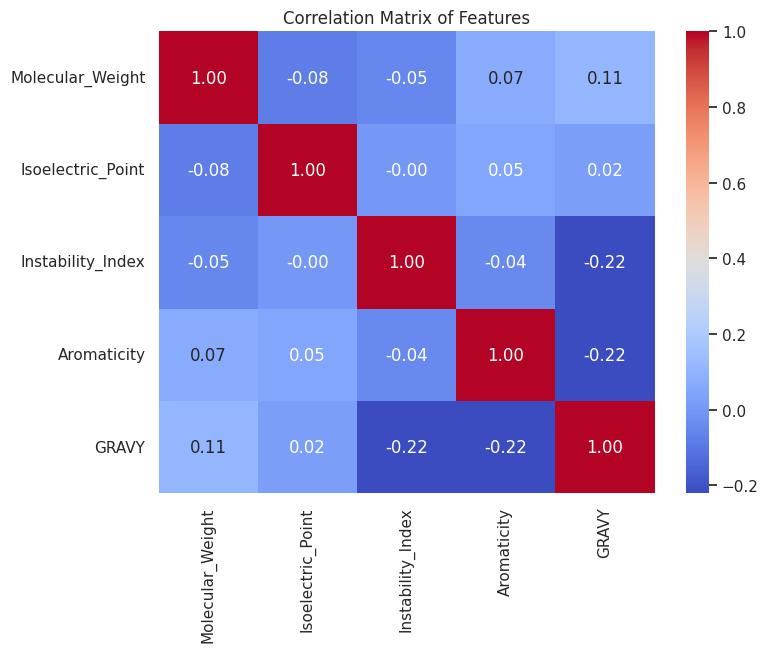

In [33]:
# Standardization
feature_cols = ['Molecular_Weight', 'Isoelectric_Point', 'Instability_Index', 'Aromaticity', 'GRAVY']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis[feature_cols])

# Correlation Check
plt.figure(figsize=(8, 6))
sns.heatmap(df_analysis[feature_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

By applying Standard Scaling, I transformed all features to a common scale (mean=0, variance=1). This ensures that features with larger numerical values do not dominate the Euclidean distance calculations in the subsequent analysis.

### Unsupervised Learning Analysis

I applied **K-Means clustering** to discover structures in the physical and chemical feature space. Also, to visualize the high-dimensional clusters, I used **PCA (Principal Component Analysis)** to project the data onto 2D space.


#### Why K-Means?

I chose **K-Means Clustering** as the unsupervised algorithm for three reasons:

1. **Standard Baseline:** It serves as a benchmark to test if simple linear separation is sufficient or not.
2. **Geometric Fit:** Since our features are standardized numerical values (e.g., weight, hydrophobicity), Euclidean distance is a biologically valid metric for similarity.
3. **Easy to interpret:** K-Means calculates "centroids" for each group, allowing us to explain clusters based on average physical properties (e.g., "This cluster represents heavy, hydrophobic proteins").

First, I performed the Elbow Method to find the optimal number of clusters mathematically.

Finding optimal k...


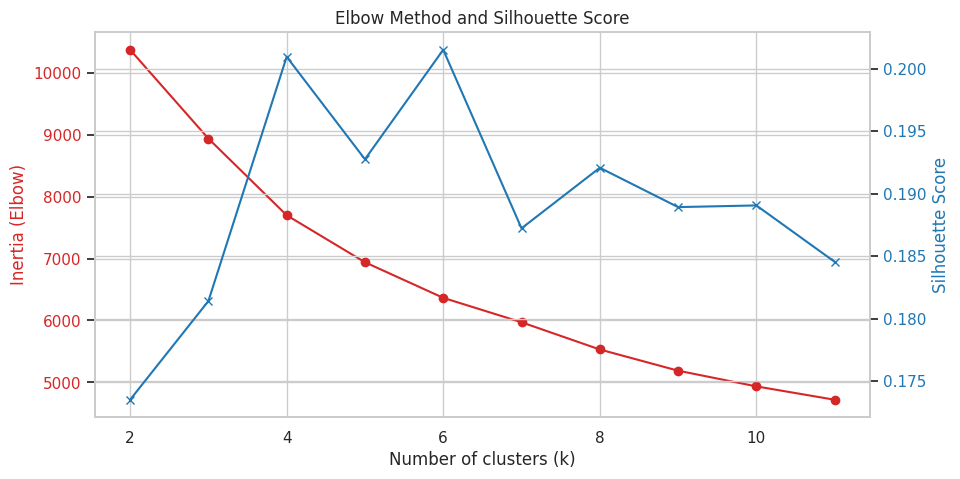

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
K_RANGE = range(2, 12)

print("Finding optimal k...")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Curve & Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_RANGE, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_RANGE, silhouette_scores, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method and Silhouette Score')
plt.show()

The inertia curve decreases smoothly **without a distinct "elbow" point**, but the Silhouette analysis suggested that **$k=4$** provides a slightly better mathematical separation than the target $k=10$ (= the number of classfications).

First, let's try with $k=4$.

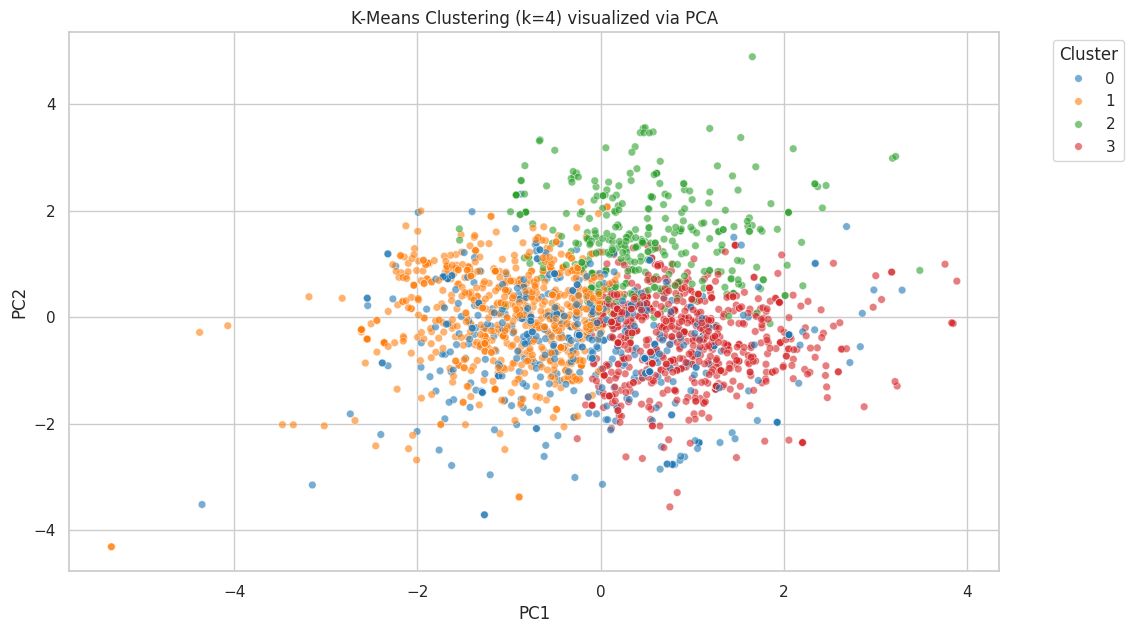

In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# K-Means Clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_analysis['Cluster'] = clusters

# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_analysis['Cluster'],
    palette='tab10', alpha=0.6, s=30
)
plt.title(f"K-Means Clustering (k={k}) visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

When applying $k=4$, I observed relatively separate regions in the PCA space (in Orange/Red/Green dots - blue dots are scattered around), representing broad physical and chemical archetypes (e.g., distinct groups of large/hydrophobic proteins vs. small/hydrophilic ones).

**However, the "biological" goal is to identify 10 specific functional classes.** Next, I would use $k=10$, which is the correct number of biological classes.

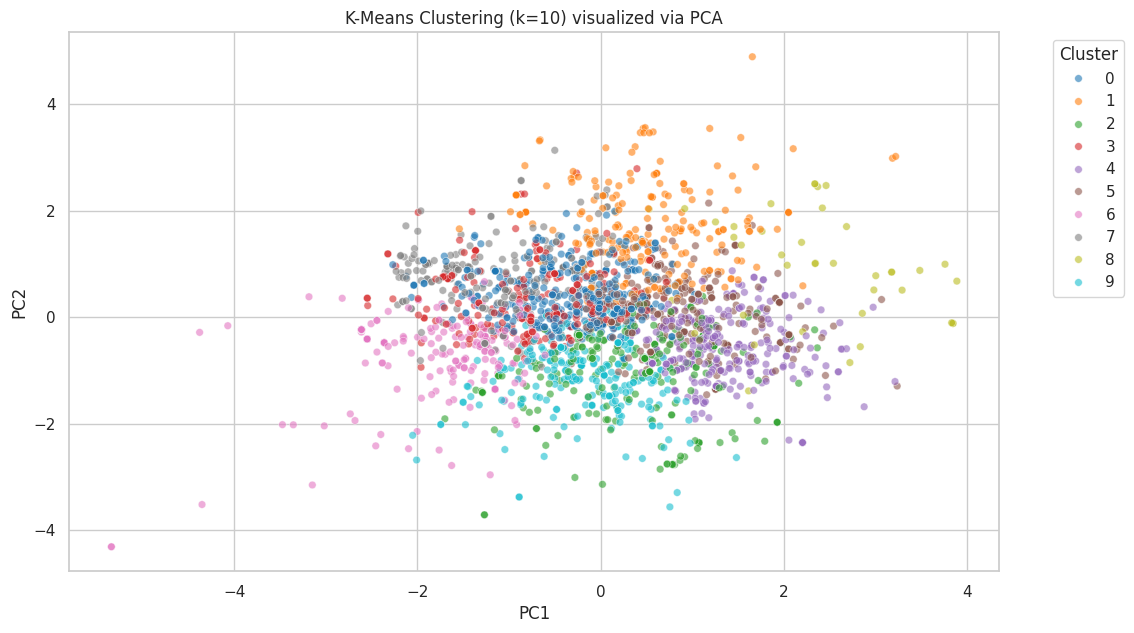

In [36]:
# K-Means Clustering
k = 10 # with k=10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_analysis['Cluster'] = clusters

# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_analysis['Cluster'],
    palette='tab10', alpha=0.6, s=30
)
plt.title(f"K-Means Clustering (k={k}) visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

When we forced the model to find 10 clusters ($k=10$) to align with the ground truth, the cluster boundaries became blurred.

This implies that while unsupervised learning captures **broad physical categories**, it struggles to resolve the **fine-grained differences** required for specific functional classification.

**Transition to Optimization:**

Given the continuous nature of the data, the clustering result might be sensitive to initialization. Before concluding on the performance of unsupervised learning, I will perform **Hyperparameter Tuning** to ensure we are using the most stable and optimal configuration for the algorithm.

### Hyperparameter Tuning

Before finalizing the clustering model, I performed a brief grid search to ensure stability and performance.
While `k` (number of clusters) is determined by the problem scope ($k=10$), other parameters like the **initialization method** (`init`) and the **number of restarts** (`n_init`) can impact performance.

Therefore, I compared the **Silhouette Score** (cluster separation) and **Inertia** (cluster compactness) across different configurations.

In [37]:
print("Tuning K-Means Hyperparameters (Fixed k=10)...")

tuning_results = []

# Parameters to test
init_options = ['k-means++', 'random'] # Smart init vs Pure random
n_init_options = [1, 10, 30] # How many times to run the algo with different seeds

for init_method in init_options:
    for n_init in n_init_options:
        # Run K-Means
        km = KMeans(n_clusters=10, init=init_method, n_init=n_init, random_state=42)
        km.fit(X_scaled)

        # Record metrics
        tuning_results.append({
            'Init_Method': init_method,
            'n_init': n_init,
            'Inertia': round(km.inertia_, 2), # Lower is better (within-cluster sum of squares)
            'Silhouette': round(silhouette_score(X_scaled, km.labels_), 4) # Higher is better
        })

# Show results sorted by Silhouette Score
df_tuning = pd.DataFrame(tuning_results).sort_values(by='Silhouette', ascending=False)
display(df_tuning)

# Best Configuration
best_config = df_tuning.iloc[0]
print(f"\nSelected Configuration: Init='{best_config['Init_Method']}', n_init={best_config['n_init']}")

Tuning K-Means Hyperparameters (Fixed k=10)...


,Init_Method,n_init,Inertia,Silhouette
5,random,30,4931.06,0.1931
4,random,10,4935.00,0.1903
3,random,1,5176.06,0.1900
2,k-means++,30,4932.45,0.1892
1,k-means++,10,4936.62,0.1891
0,k-means++,1,5089.44,0.1864



Selected Configuration: Init='random', n_init=30


### Outcome of Hyperparameter Tuning

Despite adjusting initialization methods (`k-means++`) and increasing restarts (`n_init`), the results remained largely unchanged.

* **Result:** The Silhouette Score stalled at **~0.18**, with negligible improvement.
* **Observation:** Significant overlap persists in the feature space.
* **Conclusion:** The lack of separation is **intrinsic to the data itself**, not a configuration issue. Protein functions likely form complex, non-linear structures that simple distance-based clustering cannot capture.

## vs. Supervised Learning (Hypothesis Testing)

**Hypothesis:**
The physicochemical features *do* contain predictive biological signals, but the boundaries between functional classes are too complex for simple clustering algorithms like K-Means to capture.

**Methodology:**
To test this, I trained a **Random Forest Classifier**, which is a supervised algorithm, using the exact same feature set. Unlike K-Means, Random Forest can model complex, non-linear decision boundaries. A high classification accuracy would confirm the validity of our features.

* Input: The same standardized feature vectors (`X_scaled`).
* Target: The actual biological classification labels.
* 80% Training / 20% Testing split.

Supervised Learning Accuracy: 57.11%
------------------------------------------------------------
Classification Report:

                               precision    recall  f1-score   support

                    HYDROLASE       0.33      0.21      0.26        47
HYDROLASE/HYDROLASE INHIBITOR       0.81      0.80      0.81        86
                IMMUNE SYSTEM       0.59      0.77      0.67        53
                        LYASE       0.54      0.57      0.55        49
               OXIDOREDUCTASE       0.35      0.38      0.36        42
                TRANSCRIPTION       0.52      0.63      0.57        52
                  TRANSFERASE       0.40      0.33      0.36        55
            TRANSPORT PROTEIN       0.67      0.59      0.63        54
                VIRAL PROTEIN       0.54      0.55      0.55        47
                        VIRUS       1.00      0.86      0.92        14

                     accuracy                           0.57       499
                    macr

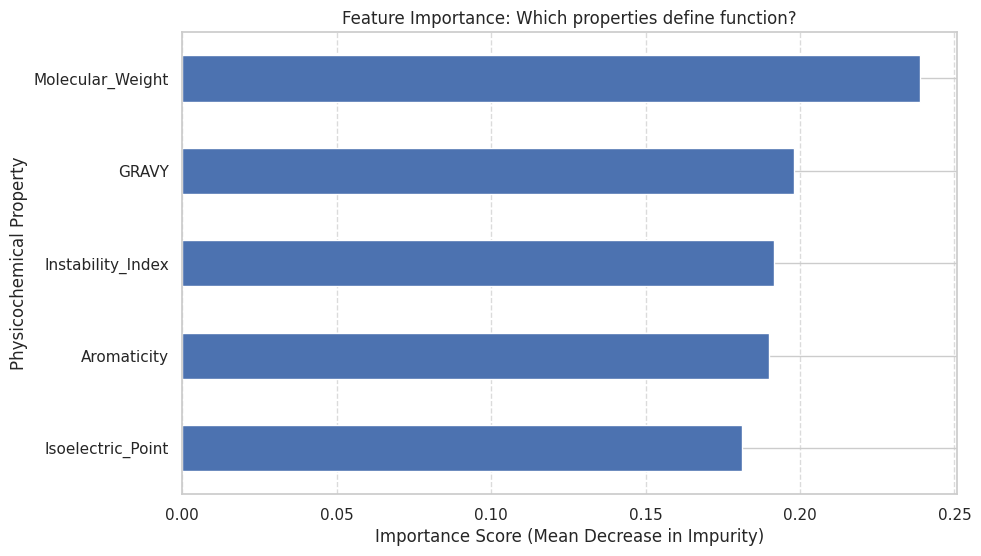

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Use the standardized features (X_scaled) and the true labels
X = X_scaled
y = df_analysis['classification']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
# n_estimators=100: Build 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluation: Predict on the unseen test set
y_pred = rf_model.predict(X_test)

# Calculate Accuracy
rf_acc = accuracy_score(y_test, y_pred)
print(f"Supervised Learning Accuracy: {rf_acc:.2%}")
print("-" * 60)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Extract and visualize which physical properties were most useful for classification
feature_cols = ['Molecular_Weight', 'Isoelectric_Point', 'Instability_Index', 'Aromaticity', 'GRAVY']
importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh')
plt.title("Feature Importance: Which properties define function?")
plt.xlabel("Importance Score (Mean Decrease in Impurity)")
plt.ylabel("Physicochemical Property")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

According to the Random Forest, Molecular Weight came out on top contributors. Basically, the model figured out that 'heavy' proteins usually do different jobs than 'light' ones.

* **Unsupervised Approach (K-Means):**
    * The algorithm struggled to find boundaries in the feature space. The clustering analysis yielded a low Silhouette Score (~0.18) and visually showed significant overlap in the PCA projection.
    * This low score implies that the data does not naturally separate into distinct groups, making it impossible to assign a meaningful "accuracy" based on geometry alone.
* **Supervised Approach (Random Forest):**
    * Despite the lack of natural separation observed above, the Random Forest classifier achieved an Accuracy of 57.11%.
    * Compared to a random baseline of 10%, this model performed approx. 6x better, proving that the features do contain some signals even if they don't form simple clusters.

# Conclusion

This project investigated whether biological protein functions could be identified solely through basic properties such as molecular weight without using sequence alignment.

### Key Takeaways

1.  **Limitations of Classical Clustering:**
    The unsupervised approach (K-Means) demonstrated that protein functions are not separated in distinct clusters. They exist on a continuous spectrum, making simple clustering insufficient for functional annotation.
2.  **Physical and Chemical Properties Contain Signal:**
    I could classify proteins with **~57% accuracy** using a supervised model, which indicates that features like *Molecular Weight* and *GRAVY* (hydrophobicity) are not random attributes but linked to biological function.
3.  **Addressing Complexity:**
    Simple features hit a performance ceiling. To achieve higher accuracy, we must handle the structural complexity of proteins using advanced methods like n-grams or Deep Learning.

While basic physical and chemical properties provide a strong baseline for characterizing proteins, accurate functional determination requires capturing the non-linear complexity.


# GitHub URL

https://github.com/thash/cuboulder/blob/main/unsupervised-algorithms-in-machine-learning/FinalProject-Unsupervised_Algorithms_in_Machine_Learning.ipynb